In [25]:


import os, sys, re
import json
import pandas as pd
import numpy as np
import datetime as dt
import subprocess
import xarray as xr
import math
import shutil
import time

import fsspec
import xarray as xr
import rioxarray
import geopandas as gpd
import requests

from typing import Union
import datetime as dt

from pcse.base import WeatherDataProvider, WeatherDataContainer
from pcse.util import ea_from_tdew, reference_ET, check_angstromAB
from pcse.exceptions import PCSEError

import logging
logging.basicConfig(
    format="%(asctime)s, %(levelname)-8s [%(filename)s:%(module)s:%(funcName)s:%(lineno)d] %(message)s",
    datefmt="%Y-%m-%d:%H:%M:%S",
    level=logging.DEBUG,
)

logger = logging.getLogger(__name__)

import requests, re, os


class AwsNasaPower:
    def __init__(self):
        self.solar_variables = ["ALLSKY_SFC_SW_DWN", "TOA_SW_DWN"]

        self.weather_variables = ["T2M",
             "T2M_MIN",
             "T2M_MAX",
             "T2MDEW",
             "WS2M",
             "PRECTOTCORR",
             "RH2M"]

        self.ds_weather = self.aws_nasapower(product='power_901_daily_meteorology_lst.zarr', 
                                             variables=self.weather_variables)
        self.ds_solar = self.aws_nasapower(product="power_901_daily_radiation_lst.zarr",
                                           variables=self.solar_variables)
        
    def aws_nasapower(self, product:str, variables: list)->xr.Dataset:
        filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{product}'
        filepath_mapped = fsspec.get_mapper(filepath)
        ds = xr.open_zarr(store=filepath_mapped, consolidated=True)

        ds = ds[variables]     
        return ds


class AWS_WOFOST(WeatherDataProvider):
    """WeatherDataProvider for using the AWS NASA POWER database with PCSE

    :param latitude: latitude to request weather data for
    :param longitude: longitude to request weather data for
    :keyword ETmodel: "PM"|"P" for selecting penman-monteith or Penman
        method for reference evapotranspiration. Defaults to "PM".
    
    TO-DO: check while init class if xr.Dataset loaded into memory or not 
    
    """
    angstA = 0.29
    angstB = 0.49
    
    MJ_to_J = lambda x: x * 1e6
    mm_to_cm = lambda x: x / 10.0
    tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
    to_date = lambda d: d.date()
    watt_to_joules = lambda x: x * 86400
    kg_m2_to_mm = lambda x: x * 86400
    K_to_C = lambda x: x - 273.15


    def __init__(self,
                latitude:float, longitude:float,
                time_start: str, time_end:str,
                ds_weather: xr.Dataset,
                ds_solar: xr.Dataset,
                ETmodel: str = "PM"):

        WeatherDataProvider.__init__(self)

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.0
        self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
        self.to_date = lambda d: d.date()
        self.watt_to_joules = lambda x: x * 86400
        self.kg_m2_to_mm = lambda x: x * 86400
        self.K_to_C = lambda x: x-273.15
        self.solar_variables = ["ALLSKY_SFC_SW_DWN", "TOA_SW_DWN"]
        self.power_meteo_variables = [
            "T2M",
            "T2M_MIN",
            "T2M_MAX",
            "T2MDEW",
            "WS2M",
            "PRECTOTCORR",
            "RH2M",
        ]
        self.ETmodel = ETmodel
        self.logger.debug('Start loading')

    
        self.ds_weather = ds_weather
                          
        self.ds_solar = ds_solar
        self.get_WOFOST_weather(latitude=latitude,
                                longitude=longitude,
                                time_start=time_start,
                                time_end=time_end)
    def aws_nasapower(self, product:str, variables: list)->xr.Dataset:
        filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{product}'
        filepath_mapped = fsspec.get_mapper(filepath)
        ds = xr.open_zarr(store=filepath_mapped, consolidated=True)

        ds = ds[variables]     
        return ds
    def select_from_xarray(self, longitude:float, latitude:float, 
                           time_start: str, time_end:str):
        msg = 'start weather selection'
        logger.debug(msg)
        print(msg)
        point_weather = self.ds_weather.sel(lon=longitude, 
                                            lat=latitude,
                                            method='nearest')
        point_weather= point_weather.sel(time=slice(time_start, time_end))
        point_solar = self.ds_solar.sel(lon=longitude,
                                        lat=latitude,
                                        method='nearest')
        point_solar= point_solar.sel(time=slice(time_start, time_end))
        msg = 'done weather selection'
        logger.debug(msg)
        print(msg)
        msg = 'start loading to pandas'
        logger.debug(msg)
        print(msg)
        df_power = self.xr_dataset_to_pandas(ds=point_weather)
        
        df_solar = self.xr_dataset_to_pandas(ds=point_solar)
        msg = 'Finish loading to pandas'
        logger.debug(msg)
        print(msg)
        df_power['DAY'] = pd.to_datetime(point_weather.time.values,
                                         format="%Y%m%d")
        
        df_solar = df_solar.apply(self.watt_to_joules) / 1e6 # Convert to MJ for A,B computing
        
        df_power = pd.concat([df_power, df_solar], axis=1)
        return df_power

    def xr_dataset_to_pandas(self, ds: xr.Dataset)->pd.DataFrame:
        """Convert xarray point to pandas -> faster than implimented"""
        dict_to_pandas = {}
        for key in list(ds.keys()):
            dict_to_pandas[key] = ds[key].values
        return pd.DataFrame(dict_to_pandas)

    def get_WOFOST_weather(self, latitude:float, longitude:float, time_start: str, time_end:str):
        
        """Handles the retrieval and processing of the NASA Power data"""
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        if latitude < -90 or latitude > 90:
            msg = "Latitude should be between -90 and 90 degrees."
            raise ValueError(msg)
        if longitude < -180 or longitude > 180:
            msg = "Longitude should be between -180 and 180 degrees."
            raise ValueError(msg)
        df_power = self.select_from_xarray(longitude=longitude,
                                            latitude=latitude,
                                            time_start=time_start, 
                                            time_end=time_end)

        # Store the informational header then parse variables
        self.description = "NASA POWER AWS S3"
        self.elevation = float(self._get_elevation(longitude=longitude,
                                                   latitude=latitude))
        self.df_power = df_power

        # Determine Angstrom A/B parameters
        self.angstA, self.angstB = self._estimate_AngstAB(df_power)

        # Convert power records to PCSE compatible structure
        df_pcse = self._POWER_to_PCSE(df_power)
        self.df_pcse = df_pcse
        # Start building the weather data containers
        self._make_WeatherDataContainers(df_pcse.to_dict(orient="records"))

    def _estimate_AngstAB(self, df_power: pd.DataFrame):
        """Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and
        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.

        :param df_power: dataframe with POWER data
        :return: tuple of Angstrom A/B values

        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn
        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for
        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while
        toa_dwn*A approaches the lower envelope of the records of swv_dwn
        values.
        """

        msg = "Start estimation of Angstrom A/B values from POWER data."
        self.logger.debug(msg)

        # check if sufficient data is available to make a reasonable estimate:
        # As a rule of thumb we want to have at least 200 days available
        if len(df_power) < 200:
            msg = (
                "Less then 200 days of data available. Reverting to "
                + "default Angstrom A/B coefficients (%f, %f)"
            )
            self.logger.warn(msg % (self.angstA, self.angstB))
            return self.angstA, self.angstB

        # calculate relative radiation (swv_dwn/toa_dwn) and percentiles
        relative_radiation = df_power.ALLSKY_SFC_SW_DWN / df_power.TOA_SW_DWN
        ix = relative_radiation.notnull()
        angstrom_a = float(np.percentile(relative_radiation[ix].values, 5))
        angstrom_ab = float(np.percentile(relative_radiation[ix].values, 98))
        angstrom_b = angstrom_ab - angstrom_a

        try:
            check_angstromAB(angstrom_a, angstrom_b)
        except PCSEError as e:
            msg = (
                "Angstrom A/B values (%f, %f) outside valid range: %s. "
                + "Reverting to default values."
            )
            msg = msg % (angstrom_a, angstrom_b, e)
            self.logger.warn(msg)
            return self.angstA, self.angstB

        msg = "Angstrom A/B values estimated: (%f, %f)." % (angstrom_a, angstrom_b)
        self.logger.debug(msg)

        return angstrom_a, angstrom_b

    def _get_elevation(self, longitude: float, latitude: float) -> float:
        """_get_elevation
        Get elevation from OpenTopoData API by lon and lat

        Args:
            longitude (float): longitude in WGS84
            latitude (float): latitude in WGS84

        Returns:
            float: elevation (m)
        """
        url = (
            f"https://api.opentopodata.org/v1/aster30m?locations={latitude},{longitude}"
        )
        resp = requests.get(url=url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            elevation = data["results"][0]["elevation"]
        else:
            elevation = 200
        return elevation

    def _make_WeatherDataContainers(self, recs):
        """Create a WeatherDataContainers from recs, compute ET and store the WDC's."""

        for rec in recs:
            # Reference evapotranspiration in mm/day
            try:
                E0, ES0, ET0 = reference_ET(
                    rec["DAY"],
                    rec["LAT"],
                    rec["ELEV"],
                    rec["TMIN"],
                    rec["TMAX"],
                    rec["IRRAD"],
                    rec["VAP"],
                    rec["WIND"],
                    self.angstA,
                    self.angstB,
                    self.ETmodel,
                )
            except ValueError as e:
                msg = (
                    ("Failed to calculate reference ET values on %s. " % rec["DAY"])
                    + ("With input values:\n %s.\n" % str(rec))
                    + ("Due to error: %s" % e)
                )
                raise PCSEError(msg)

            # update record with ET values value convert to cm/day
            rec.update({"E0": E0 / 10.0, "ES0": ES0 / 10.0, "ET0": ET0 / 10.0})

            # Build weather data container from dict 't'
            wdc = WeatherDataContainer(**rec)

            # add wdc to dictionary for thisdate
            self._store_WeatherDataContainer(wdc, wdc.DAY)

    def _POWER_to_PCSE(self, df_power):
        # find all rows with one or more missing values (NaN)
        df_power = df_power.ffill()
        ix = df_power.isnull().any(axis=1)
        # Get all rows without missing values
        df_power = df_power[~ix]

        # Convert POWER data to a dataframe with PCSE compatible inputs
        df_pcse = pd.DataFrame(
            {
                "TMAX": df_power.T2M_MAX.apply(self.K_to_C),
                "TMIN": df_power.T2M_MIN.apply(self.K_to_C),
                "TEMP": df_power.T2M.apply(self.K_to_C),
                "IRRAD": df_power.ALLSKY_SFC_SW_DWN.apply(self.MJ_to_J),
                "RAIN": df_power.PRECTOTCORR.apply(self.kg_m2_to_mm).apply(self.mm_to_cm),
                "WIND": df_power.WS2M,
                "VAP": df_power.T2MDEW.apply(self.K_to_C).apply(self.tdew_to_hpa),
                "DAY": df_power.DAY.apply(self.to_date),
                "LAT": self.latitude,
                "LON": self.longitude,
                "ELEV": self.elevation,
            }
        )

        return df_pcse


In [26]:
aws = AwsNasaPower()

In [54]:
time_start = '2020-01-01'
time_end = dt.date.today().strftime("%Y-%m-%d")
wdp = AWS_WOFOST(latitude=52, 
                longitude=5,
                time_start=time_start,
                time_end=time_end,
                ds_solar=aws.ds_solar,
                ds_weather=aws.ds_weather)

start weather selection
done weather selection
start loading to pandas
Finish loading to pandas


In [63]:
type(wdp)

__main__.AWS_WOFOST

In [56]:

import pcse
import yaml
from pcse.models import Wofost71_WLP_FD, Wofost71_PP
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from pcse.base import ParameterProvider
from pcse.engine import Engine
from pcse.fileinput import csvweatherdataprovider

In [57]:
crop_data_loader =YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master")
all_crops = crop_data_loader.get_crops_varieties()
cropd = YAMLCropDataProvider()

sited = WOFOST71SiteDataProvider(WAV=50)

soild = DummySoilDataProvider()

In [59]:
row={}
row['day_sowing'] = dt.datetime.strptime('2022-05-01',  '%Y-%m-%d')
row['day_cce'] = dt.datetime.strptime('2022-10-15',  '%Y-%m-%d')
campaign_start_date = dt.datetime.strftime(row['day_sowing'] - dt.timedelta(20),
                                            '%Y-%m-%d')
emergence_date = dt.datetime.strftime(row['day_sowing'], '%Y-%m-%d')
harvest_date = dt.datetime.strftime(row['day_cce'], '%Y-%m-%d')
max_duration = 300

crop_name = 'sugarbeet'
variety_name = 'Sugarbeet_601'
agro_yaml = f"""
- {campaign_start_date}:
    CropCalendar:
        crop_name: {crop_name}
        variety_name: {variety_name}
        crop_start_date: {emergence_date}
        crop_start_type: emergence
        crop_end_date: {harvest_date}
        crop_end_type: harvest
        max_duration: {max_duration}
    TimedEvents: null
    StateEvents: null
"""

agro = yaml.safe_load(agro_yaml)

firstkey = list(agro[0])[0]
cropcalendar = agro[0][firstkey]['CropCalendar'] 

cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

wofost = Wofost71_WLP_FD(params, wdp, agro)

wofost.run_till_terminate()

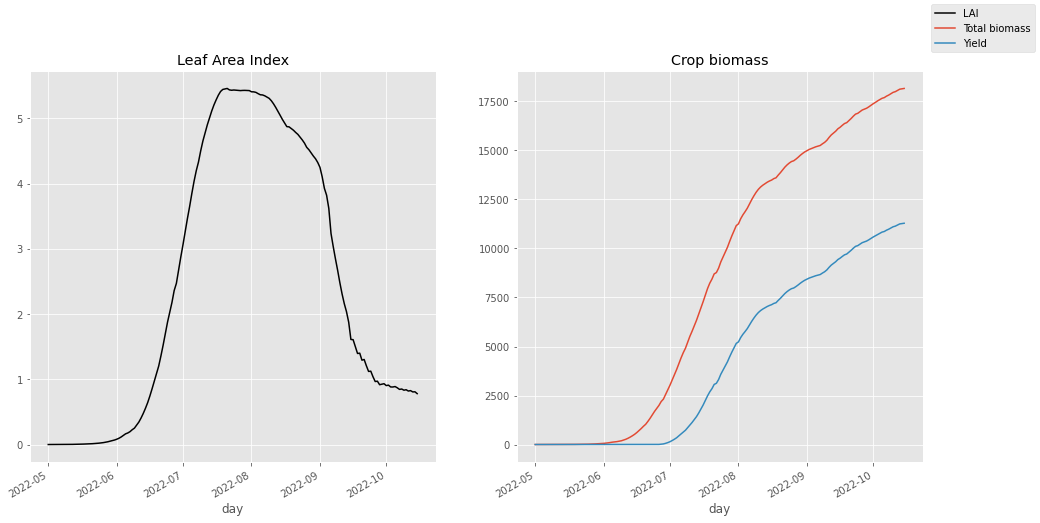

In [62]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use("ggplot")
dfPP = pd.DataFrame(wofost.get_output()).set_index("day")


fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dfPP.LAI.plot(ax=axis1, label="LAI", color='k')
dfPP.TAGP.plot(ax=axis2, label="Total biomass")
dfPP.TWSO.plot(ax=axis2, label="Yield")
axis1.set_title("Leaf Area Index")
axis2.set_title("Crop biomass")
fig.autofmt_xdate()
r = fig.legend()



In [53]:
all_crops['sugarbeet']

dict_keys(['Sugarbeet_601', 'Sugarbeet_602', 'Sugarbeet_603', 'Sugarbeet_604'])

In [65]:
os.getcwd()

'/Users/mikhailgasanov/Documents/GIT/CropBot/notebooks'

In [5]:
text = ("The model calculation for the field is started.\n"
            "This operation takes about a minute...\n"
            "More about PCSE/WOFOST: [Docs](https://wofost.readthedocs.io/en/latest/)"
            "If nothing happens after 5 minutes, type /cancel and try again with /start")

In [6]:
print(text)

The model calculation for the field is started.
This operation takes about a minute...
More about PCSE/WOFOST: [Docs](https://wofost.readthedocs.io/en/latest/)If nothing happens after 5 minutes, type /cancel and try again with /start
